In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(["seaborn-paper", "seaborn-white"])
plt.rcParams["image.cmap"] = "viridis"

np.random.seed(321)

## Data generation

The following function can be used to generate a 2D dataset, with observations belonging to either the "0" or "1" class.

In [2]:
def generate_data(n, alpha=0.1, beta=1, initial_point=(0, 0), add_bias=True):
    """
    Iteratively generate a 2-class, 2D dataset with a "nudge-and-flip" method.
    
    Keyword arguments:
    alpha -- larger value increases spread (default 0.1)
    beta -- larger value increases jitter (default 1.0)
    initial_point -- coordinate of first observation
    add_bias -- Add a bias feature (i.e. prepend a column of 1s)
    """
    
    data = np.empty((n, 2))
    # Define an initial point
    data[0, :] = initial_point
    
    # Randomly "scale" the upcoming reflection
    a = np.random.uniform(low=(-1-alpha), high=(-1+alpha), size=n)
    
    # "Flip" previous point and add some noise
    for k in range(1, n):
        data[k, ] = a[k]*data[k-1, :] + beta*np.random.normal(0, 1, size=2)
    
    # Add a bias variable
    if add_bias:
        data = np.hstack((np.ones((n, 1)), data))
    
    # Labels are two classes (0, 1), strictly alternating, because of "flipping" above
    labs = np.array([0, 1]*(n//2 + 1))[:n]
    
    return data, labs

An example dataset is generated and visualised below.

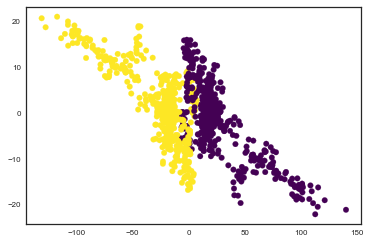

In [3]:
demo_data, demo_labs = generate_data(1000, initial_point=[10, 10])

plt.scatter(demo_data[:, 1], demo_data[:, 2], c=demo_labs)

## Auxiliary functions

For validation and testing, we need some way of splitting up our dataset into separate sets.

In [4]:
def make_sets(data, labels, props, shuffle=True):
    """
    Divide data/labels into proportional sets.
    
    Keyword arguments:
    data -- dataset of features
    labels -- matching set of labels
    props -- list of proportions, which must sum to 1, e.g. [0.6, 0.2, 0.2] for a 60%/20%/20% split
    """
    
    if sum(props) != 1:
        raise ValueError("proportions must sum to 1")
    
    m = data.shape[0]
    idx = np.random.permutation(m) if shuffle else range(m)
    
    sets = []
    cursor = 0
    
    for p in props:
        dset = data[idx, :][cursor:(cursor+int(p*m)), :]
        sets.append(dset)
        lset = labels[idx][cursor:(cursor+int(p*m))]
        sets.append(lset)
        
        cursor = int(p*m)
    
    return sets

Here we split our demo data into three distinct `*_train`, `*_val` and `*_test` sets.

In [5]:
X_train, y_train, X_val, y_val, X_test, y_test = make_sets(demo_data, demo_labs, [0.6, 0.2, 0.2])

Note that we had 1000 observations to begin with:

In [6]:
X_train.shape, y_val.shape

((600, 3), (200,))

We will require an activation function:

In [7]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

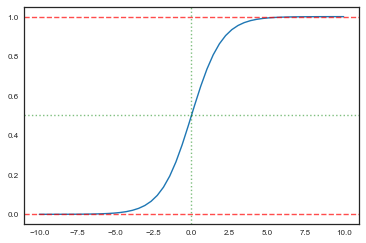

In [8]:
x = np.linspace(-10, 10)
plt.plot(x, sigmoid(x))

plt.axhline(y=0, color="r", linestyle="--", alpha=0.7)
plt.axhline(y=1, color="r", linestyle="--", alpha=0.7)
plt.axhline(y=0.5, color="g", linestyle=":", alpha=0.5)
plt.axvline(x=0, color="g", linestyle=":", alpha=0.5)

Our model gives predictions by calculating a weighted sum, and activating the result. We use matrix operations to efficiently do this for multiple observations at a time.

In [9]:
def predict(features, weights):
    Z = np.dot(features, weights)
    return sigmoid(Z)

We initialise our weights with 0 (but anything would be fine). There are 3 weights: one for the bias unit, and one for each of the two features.

In [10]:
init_weights = np.zeros(3)

In [11]:
preds = predict(X_val, init_weights)
preds[:10]

array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])

Our predictions are currently values in the range between 0 and 1. To give a class to each prediction we need to set some threshold (generally 0.5) which defines the boundary between classes.

In [12]:
def classify(predictions, threshold=0.5):
    return (predictions >= threshold).astype(int)

In [13]:
preds_classes = classify(preds)
preds_classes[:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

To assess the performance of the model, we'll need some sort of metric - accuracy is simplest, and fine for us since our classes are balanced. Pre-training we'd expect ~50% accuracy, equivalent to randomly guessing.

In [14]:
def accuracy(predicted, actual):
    return np.mean(predicted == actual)

In [15]:
accuracy(preds_classes, y_val)

0.49

Although it won't be pretty to look at for now, we'll also want to look at the "decision boundary" later, so we'll define a function that plots predictions behind the data as a contoured surface.

In [16]:
def plot_boundary(data, labels, weights, subdivs=200, alpha=0.2):
    
    # Get plot limits
    fig, ax = plt.subplots()
    ax.scatter(data[:, 1], data[:, 2], c=labels)

    xmin, xmax = ax.get_xlim()
    xstep = (xmax-xmin)/subdivs
    ymin, ymax = ax.get_ylim()
    ystep = (ymax-ymin)/subdivs
    
    # Clear axes
    plt.cla()
    
    # Plot again!
    grid = np.mgrid[xmin:xmax:xstep, ymin:ymax:ystep].reshape(2, -1).T
    n = grid.shape[0]
    grid_with_bias = np.hstack((np.ones((n, 1)), grid))
    
    preds = predict(grid_with_bias, weights)
    
    plt.contourf(np.arange(xmin, xmax, xstep), np.arange(ymin, ymax, ystep),
                 preds.reshape(-1, subdivs).T,
                 alpha=alpha)

    plt.scatter(data[:, 1], data[:, 2], c=labels)
    
    plt.contour(np.arange(xmin, xmax, xstep), np.arange(ymin, ymax, ystep),
                preds.reshape(-1, subdivs).T,
                levels=[0.5],
                colors="black", linestyles="dashed")
    
    plt.show()
    
    return None

C:\Users\ojones\AppData\Local\Continuum\miniconda3\lib\site-packages\matplotlib\contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


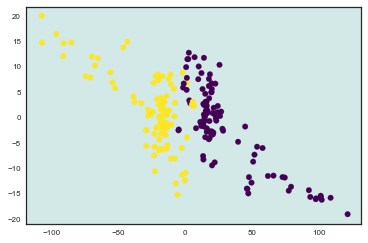

In [17]:
plot_boundary(X_val, y_val, init_weights)

## Simple logistic regression

First we define the binary cross-entropy cost function...

In [18]:
def get_cost(features, labels, weights):
    
    m = features.shape[0]
    preds = predict(features, weights)
    
    cost = -(labels*np.log(preds) + (1-labels)*np.log(1-preds)).sum()
    
    # Average cost per observation
    return cost/m
    

In [19]:
get_cost(X_train, y_train, init_weights)

0.6931471805599453

Then the first-order gradient of the cost function, with respect to the model's weights.

In [20]:
def get_grad(features, labels, weights):
    
    m = features.shape[0]
    preds = predict(features, weights)
    
    # Average gradient over all observations
    grad = np.dot(features.T, (preds - labels)) / m
    
    return grad

In [21]:
get_grad(X_train, y_train, init_weights)

array([ 0.01333333, 13.11543754, -0.77495361])

Now we define a basic training routine, which runs either for the number of iterations specified in `iters` or terminates earlier if an improvement of less than `tolerance` is made to the cost. It returns the optimised weights and the values of the cost function at all iterations.

In [22]:
def train(features, labels, init_weights, iters=1000, rate=0.1, tolerance=1e-6, verbose=True, report_level=100):

    cost = get_cost(features, labels, init_weights)
    
    if verbose:
        print("Training in progress...")
        print("")
        print("Iter | Cost")
        print("---- | ----")
        print("0000 |", cost)

    cost_history = np.empty(iters+1)
    cost_history[0] = cost
    weights = init_weights[:]
    
    for k in range(1, iters+1):
        
        # Update weights based on gradient of cost function
        grad = get_grad(features, labels, weights)
        weights = weights - rate*grad
        
        new_cost = get_cost(features, labels, weights)
        
        # Stopping criterion
        if abs(cost - new_cost) < tolerance:
            if verbose:
                print("Tolerance reached - terminating early!")
            
            cost_history = cost_history[:k]
            break
            
        else:        
            cost = new_cost
            cost_history[k] = cost
        
            if verbose and k % report_level == 0:
                print(str(k).zfill(4), "|", cost)
    
    if verbose:
        print("")
        print("Training complete!")
        print("Iterations completed:", k)
        print("Final cost:", cost_history[-1])
    
    return weights, cost_history

Let's try running this with a smallish learning rate.

In [23]:
optw, ch = train(X_train, y_train, init_weights, iters=2000, rate=0.01, report_level=10)

Training in progress...

Iter | Cost
---- | ----
0000 | 0.6931471805599453
0010 | 0.1678468407907179
0020 | 0.15540493583957077
0030 | 0.1502942358492958
0040 | 0.14777605914446323
0050 | 0.14641236507851643
0060 | 0.1456291885227473
0070 | 0.14516092121184054
0080 | 0.1448725560446095
0090 | 0.14469086809145348
0100 | 0.14457421946061733
0110 | 0.14449807572248818
0120 | 0.14444757848656517
0130 | 0.14441353401468582
0140 | 0.14439015600507227
0150 | 0.14437375283617332
0160 | 0.1443619433473207
Tolerance reached - terminating early!

Training complete!
Iterations completed: 161
Final cost: 0.1443619433473207


Let's inspect the cost history (we expect a smooth decrease) and the optimum weights.

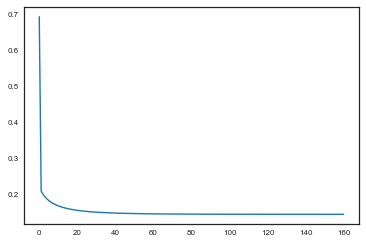

In [24]:
plt.plot(ch)

In [25]:
optw

array([-0.00832463, -0.25347881, -0.12698687])

Now we can assess the accuracy of our trained model...

In [26]:
preds = predict(X_val, optw)
preds_classes = classify(preds)

accuracy(preds_classes, y_val)

0.96

... and plot the new decision boundary!

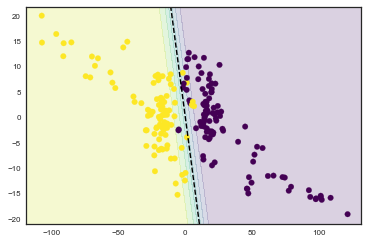

In [27]:
plot_boundary(X_val, y_val, optw)

## Regularisation

Large weights increase sensitivity of output to small changes in input. It would be better if we coukd "spread" this sensitivity over the weights, to reduce reliance on any individual weights, thus improving robustness (and hopefully improving generalisation).

We'll discourage large weights by adding a penalty term to the cost function: (squared) L2-norm of all weights. This means we need to redefine our cost/grad functions.

In [28]:
def get_cost(features, labels, weights, gamma):
    
    m = features.shape[0]
    preds = predict(features, weights)
    
    # Log-loss cost function
    cost = -(labels*np.log(preds) + (1-labels)*np.log(1-preds)).sum()
    
    # Add regularisation term
    cost = cost + (gamma/2)*(weights[1:]**2).sum()
    
    # Average cost per observation
    return cost/m
    

In [29]:
get_cost(X_train, y_train, init_weights, 100)

0.6931471805599453

In [30]:
def get_grad(features, labels, weights, gamma):
    
    m = features.shape[0]
    preds = predict(features, weights)
    
    # Gradient of cost function
    grad = np.dot(features.T, (preds - labels))
    
    # Add gradient of regularisation term
    regs = gamma*weights
    regs[0] = 0
    grad = grad + regs
    
    # Average grad per observation
    return grad/m

In [31]:
get_grad(X_train, y_train, init_weights, 100)

array([ 0.01333333, 13.11543754, -0.77495361])

Likely there will be virtually no difference here, but we would see the effect more clearly if we had more dimensions...

## Variable step size

Multiple possible approaches - but we'll implement a simple "grow/slash" method, which successively increases the learning rate at each iteration, and then reduces it dramatically when it is too large.

We redefine our training method to include a `gamma` parameter (to control regularisation) and using the new adaptive learning rate.

In [32]:
def train(features, labels, init_weights, iters=1000, rate=0.1, gamma=0, tolerance=1e-6, verbose=True, report_level=100):

    cost = get_cost(features, labels, init_weights, gamma)
    
    if verbose:
        print("Training in progress...")
        print("")
        print("Iter | Cost")
        print("---- | ----")
        print("0000 |", cost)

    cost_history = np.empty(iters+1)
    cost_history[0] = cost
    weights = init_weights[:]
    
    for k in range(1, iters+1):
        
        # Update weights based on gradient of cost function
        grad = get_grad(features, labels, weights, gamma)
        
        new_weights = weights - rate*grad
        new_cost = get_cost(features, labels, new_weights, gamma)
        
        while np.isnan(new_cost) or new_cost > cost:
            if verbose:
                print("  Rate change!", rate, "->", rate/2)
            rate = rate/2
            new_weights = weights - rate*grad
            new_cost = get_cost(features, labels, new_weights, gamma)
        
        # Grow rate
        rate = rate*1.1
        
        weights = new_weights
        
        # Stopping criterion
        if abs(cost - new_cost) < tolerance:
            if verbose:
                print("Tolerance reached - terminating early!")
            
            cost_history = cost_history[:k]
            break
            
        else:        
            cost = new_cost
            cost_history[k] = cost
        
            if verbose and k % report_level == 0:
                print(str(k).zfill(4), "|", cost)
    
    if verbose:
        print("")
        print("Training complete!")
        print("Iterations completed:", k)
        print("Final cost:", cost_history[-1])
    
    return weights, cost_history

Let's retrain...

In [33]:
optw, ch = train(X_train, y_train, init_weights, rate=1, gamma=100, iters=2000, report_level=2)

Training in progress...

Iter | Cost
---- | ----
0000 | 0.6931471805599453
  Rate change! 1 -> 0.5
  Rate change! 0.5 -> 0.25
  Rate change! 0.25 -> 0.125
  Rate change! 0.125 -> 0.0625
  Rate change! 0.0625 -> 0.03125
  Rate change! 0.03125 -> 0.015625
0002 | 0.17558679495910615
0004 | 0.16914013383163512
0006 | 0.16376693074874116
0008 | 0.15950186240550793
0010 | 0.15629650797145545
0012 | 0.15403143070168135
0014 | 0.15254001330694555
0016 | 0.15163648836825025
0018 | 0.15114151837871323
0020 | 0.15090157501473225
0022 | 0.15080050055796923
0024 | 0.1507624510500704
0026 | 0.1507464412502737
0028 | 0.150735182847062
0030 | 0.15072336482050624
0032 | 0.15070983619777578
0034 | 0.15069436101736655
0036 | 0.15067686073428302
0038 | 0.150657351738181
0040 | 0.15063597837373352
0042 | 0.15061305187315166
0044 | 0.15058908278872046
0046 | 0.1505647945520386
0048 | 0.15054110214549063
0050 | 0.15051903980747267
0052 | 0.15049962938639536
0054 | 0.15048370001947808
0056 | 0.150471713501299

C:\Users\ojones\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
C:\Users\ojones\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in multiply
  import sys


Note that we converged and terminated in many fewer iterations!

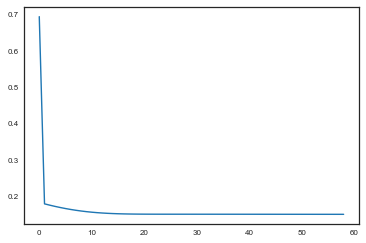

In [34]:
plt.plot(ch)

In particular note the sharper elbow in plot (as a result of adaptive rate).

For now, we don't see much adaptation _during_ training... though it means we don't have to be quite so careful with our initial rate (we can just set it "too high" and let the backtracking work its way back down).

We wouldn't expect our weights to be too different to before, though due to regularisation they might now be slightly smaller in magnitude.

In [35]:
optw

array([-0.1002087 , -0.24030256, -0.12069693])

Certainly we would hope that our accuracy and decision boundary are similar!

In [36]:
preds = predict(X_val, optw)

In [37]:
preds_classes = classify(preds)
accuracy(preds_classes, y_val)

0.96

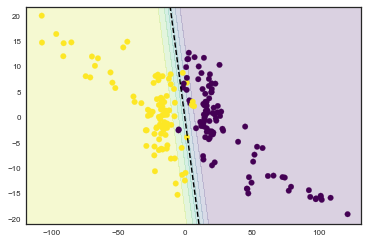

In [38]:
plot_boundary(X_val, y_val, optw)

We might now want to tune our hyperparameters - e.g. gamma - either by trial and error or some more methodical method such as grid search...

In [39]:
gammas = [0.1, 0.3, 1, 3, 10, 30, 100, 300, 1000, 3000, 10000]
costs = []
accs = []

for gamma in gammas:
    print("gamma:", gamma)
    optw, ch = train(X_train, y_train, init_weights, rate=1, gamma=gamma, iters=2000, verbose=False)
    preds = predict(X_val, optw)
    preds_classes = classify(preds)
    accs.append(accuracy(preds_classes, y_val))
    costs.append(ch[-1])

gamma: 0.1
gamma: 0.3
gamma: 1
gamma: 3
gamma: 10
gamma: 30
gamma: 100
gamma: 300
gamma: 1000
gamma: 3000
gamma: 10000


C:\Users\ojones\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
C:\Users\ojones\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in multiply
  import sys


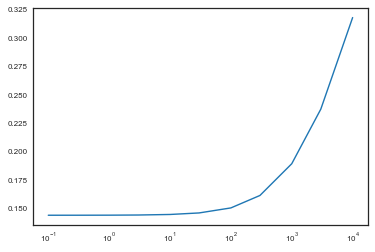

In [40]:
plt.plot(gammas, costs)
plt.xscale("log")

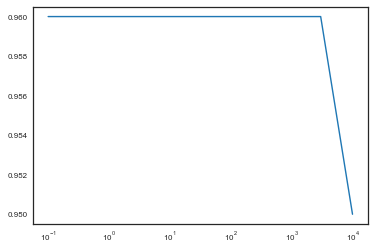

In [41]:
plt.plot(gammas, accs)
plt.xscale("log")

Really it looks like our regularisation is having virtually no effect at all, until our scale parameter `gamma` is ridiculously large! And then, the effect is certainly not beneficial.

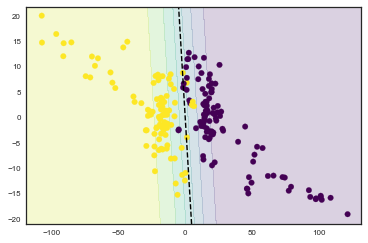

In [42]:
plot_boundary(X_val, y_val, optw)

We'll choose `gamma=1` and retrain one last time. The performance on the test set then indicates how well we are likely to perform on unseen data.

In [43]:
optw, ch = train(X_train, y_train, init_weights, rate=0.01, gamma=1, iters=2000, verbose=False)

In [44]:
preds = predict(X_test, optw)
preds_classes = classify(preds)
accuracy(preds_classes, y_test)

0.945

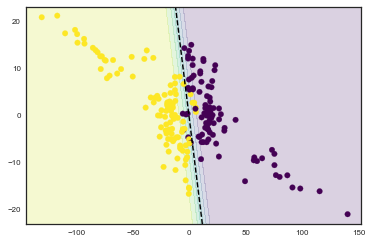

In [45]:
plot_boundary(X_test, y_test, optw)

## Experimental: Generating higher-dimensional problems

Choose negative/positive range - all positive leads to potentially all observations on one side of boundary.

In [46]:
m = 10000
d = 3000

X = np.random.uniform(-1, 1, size=(m, d))

In [47]:
X.shape

(10000, 3000)

`gamma` will control the spread of results shortly, and will correspond to regularisation later...

In [48]:
gamma = 0.3
w = np.random.normal(0, gamma**2, size=d)

In [49]:
w.shape

(3000,)

In [50]:
mu = sigmoid(np.dot(X, w))

In [51]:
mu.shape

(10000,)

We expect our linear outputs to be approximately normal here, since `w` is normal.

(array([  20.,  137.,  755., 2008., 2885., 2547., 1226.,  365.,   50.,
           7.]), array([-10.36255555,  -8.17410153,  -5.98564751,  -3.79719348,
         -1.60873946,   0.57971456,   2.76816858,   4.95662261,
          7.14507663,   9.33353065,  11.52198467]), <a list of 10 Patch objects>)

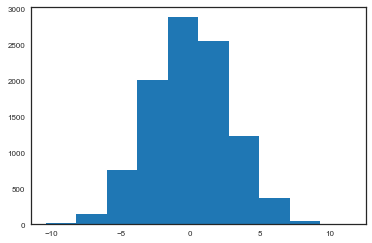

In [52]:
plt.hist(np.dot(X, w))

And we want our activated outputs to fall in general close to 0 or 1, but with some intermediate values for the sake of interest.

(array([2229.,  947.,  735.,  574.,  520.,  562.,  581.,  722.,  944.,
        2186.]),
 array([3.15926158e-05, 1.00027442e-01, 2.00023292e-01, 3.00019142e-01,
        4.00014992e-01, 5.00010841e-01, 6.00006691e-01, 7.00002541e-01,
        7.99998391e-01, 8.99994241e-01, 9.99990090e-01]),
 <a list of 10 Patch objects>)

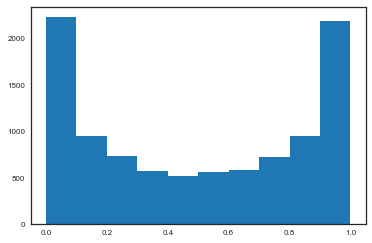

In [53]:
plt.hist(mu)

We now generate labels which are 1 with a probability of `mu` (activated output), and 0 otherwise, for each observation.

In [54]:
y = np.random.binomial(1, mu, size=m)

With symmetry of sigmoid, we expect approx hald of our observations to have a label of 1, and half of 0...

In [55]:
sum(y)

4926

Now we proceed to train as before on this data.

In [56]:
X_train, y_train, X_val, y_val, X_test, y_test = make_sets(X, y, [0.6, 0.2, 0.2])

In [57]:
init_w = np.random.uniform(-0.1, 0.1, d)

In [58]:
optw, ch = train(X_train, y_train, init_w, rate=4, gamma=1, iters=5000, report_level=5)

Training in progress...

Iter | Cost
---- | ----
0000 | 1.011704686695222
0005 | 0.28233903497141793
0010 | 0.19265892890934527
0015 | 0.14438333626161776
0020 | 0.11066062834924285
0025 | 0.08596094550219581
0030 | 0.06876567797410332
0035 | 0.058217204070738805
  Rate change! 123.650722131483 -> 61.8253610657415
  Rate change! 61.8253610657415 -> 30.91268053287075
0040 | 0.05603689094547328
  Rate change! 45.25925556817607 -> 22.629627784088036
0045 | 0.05439981363583461
0050 | 0.05324755917052514
  Rate change! 71.02146599221592 -> 35.51073299610796
0055 | 0.05243126444700643
  Rate change! 57.19039059756185 -> 28.595195298780926
0060 | 0.0519298019520018
0065 | 0.05152549139434756
  Rate change! 74.16857220130005 -> 37.084286100650026
0070 | 0.051229069866970595
  Rate change! 49.3591847999652 -> 24.6795923999826
  Rate change! 27.14755163998086 -> 13.57377581999043
  Rate change! 13.57377581999043 -> 6.786887909995215
  Rate change! 6.786887909995215 -> 3.3934439549976076
  Rate c

C:\Users\ojones\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
C:\Users\ojones\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in multiply
  import sys


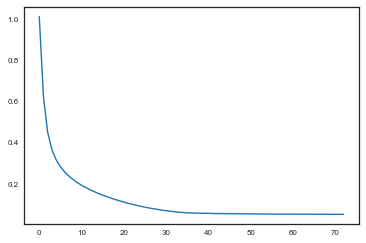

In [59]:
plt.plot(ch)

In [60]:
preds = predict(X_train, optw)
preds_classes = classify(preds)
accuracy(preds_classes, y_train)

1.0

In [61]:
preds = predict(X_val, optw)
preds_classes = classify(preds)

In [62]:
accuracy(preds_classes, y_val)

0.707

If we try a few different values for `gamma`, we _should_ observe that our highest accuracy comes at the `gamma` value we used during our data generation process...

In [63]:
gammas = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100, 300]
accs = []
final_costs = []

for gamma in gammas:
    print("Training with gamma=" + str(gamma))
    optw, ch = train(X_train, y_train, init_w, rate=4, gamma=gamma, iters=5000, verbose=False)
    preds = predict(X_val, optw)
    preds_classes = classify(preds)
    accs.append(accuracy(preds_classes, y_val))
    final_costs.append(ch[-1])

Training with gamma=0.01


C:\Users\ojones\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
C:\Users\ojones\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in multiply
  import sys


Training with gamma=0.03
Training with gamma=0.1
Training with gamma=0.3
Training with gamma=1
Training with gamma=3
Training with gamma=10
Training with gamma=30
Training with gamma=100
Training with gamma=300


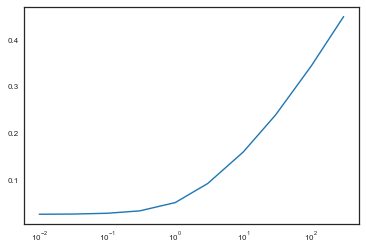

In [64]:
plt.plot(gammas, final_costs)
plt.xscale("log")

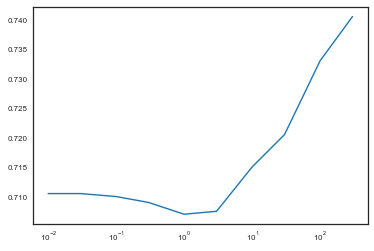

In [65]:
plt.plot(gammas, accs)
plt.xscale("log")

The results seem inconclusive, but for now we'll move on.